# <h><center>⭐️Transformer Anatomy⭐️</center></h>

## ***First focus on Encoder Architecture***

<img src='https://github.com/nlp-with-transformers/notebooks/raw/c2db380169af910eed0ca5c61b7882f3caa18cf3//images/chapter03_encoder-zoom.png'>


### **One of the best book for self learner:**

## **Full reference and credit: NLP with Transformer book**

In [ ]:
!pip install transformers

In [ ]:
!pip install bertviz

# Self Attention

A self-attention module takes in n inputs and returns n outputs. What happens in this module? In layman’s terms, the self-attention mechanism allows the inputs to interact with each other (“self”) and find out who they should pay more attention to (“attention”). The outputs are aggregates of these interactions and attention scores.

<img src='https://miro.medium.com/max/700/1*_92bnsMJy8Bl539G4v93yg.gif'>

credit gif (clear explaniation) : https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a

# **Backhand of Self-attention process - This custom data**

Full credit: https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a

## **Steps 1,2,3: Prepare input, Initialise weight, Derive**

In [ ]:
#Prepare inputs

import torch

x = [
  [1, 0, 1, 0], # Input 1
  [0, 2, 0, 2], # Input 2
  [1, 1, 1, 1]  # Input 3
 ]
x = torch.tensor(x, dtype=torch.float32)

#Initialize weight
w_key = [
  [0, 0, 1],
  [1, 1, 0],
  [0, 1, 0],
  [1, 1, 0]
]
w_query = [
  [1, 0, 1],
  [1, 0, 0],
  [0, 0, 1],
  [0, 1, 1]
]
w_value = [
  [0, 2, 0],
  [0, 3, 0],
  [1, 0, 3],
  [1, 1, 0]
]
w_key = torch.tensor(w_key, dtype=torch.float32)
w_query = torch.tensor(w_query, dtype=torch.float32)
w_value = torch.tensor(w_value, dtype=torch.float32)

#Derive Key, query, Value

keys = x @ w_key
querys = x @ w_query
values = x @ w_value

print(keys)
print(querys)
print(values)


## **NextSteps 4,5: Calculate attention score, Calculate softmax**

In [ ]:
#Calculate Attention scores
attn_scores = querys @ keys.T

print('attn_scores:',attn_scores)

# calculate softmax
from torch.nn.functional import softmax

attn_scores_softmax = softmax(attn_scores, dim=-1)

print('attn_scores_softmax:',attn_scores_softmax)

attn_scores_softmax = [
  [0.0, 0.5, 0.5],
  [0.0, 1.0, 0.0],
  [0.0, 0.9, 0.1]
]
attn_scores_softmax = torch.tensor(attn_scores_softmax)

## **Step6: Multiply scores with values**

In [ ]:
weighted_values = values[:,None] * attn_scores_softmax.T[:,:,None]
weighted_values

## **Final steps: Output**

In [ ]:
#Sum weighted values
outputs = weighted_values.sum(dim=0)
outputs

# **Easily do one step above all the process and Visualize - Huggingface**

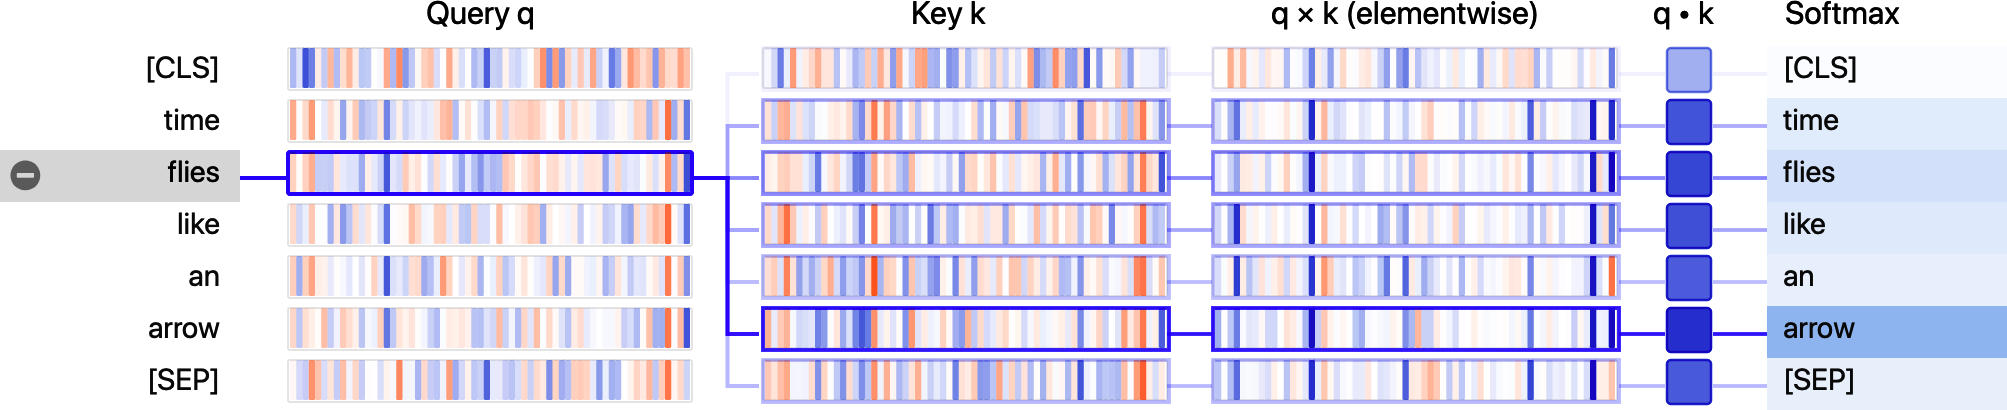

In [ ]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

In [ ]:
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = 'VK is one of the best Problem solver'
show(model,"bert", tokenizer,text,display_mode='light',layer = 0,head=0)

# **Torch - my custom text create the Self attention - Pytorch**

<img src='https://github.com/nlp-with-transformers/notebooks/raw/c2db380169af910eed0ca5c61b7882f3caa18cf3//images/chapter03_attention-ops.png'>

In [ ]:
#Tokenize
inputs = tokenizer(text, return_tensors='pt',add_special_tokens=False)
print('Token_Everyinput: ',inputs.input_ids)
print('')

#TokenEmbed
from torch import nn
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size,config.hidden_size)
print('token_embed:', token_emb)
print('')

#input embed
input_emb = token_emb(inputs.input_ids)
print('Input_embed: ', input_emb.size()) # batch_size,seq_len,hidden_dim
print('')
#Calculate the attention score

import torch
from math import sqrt

query = key = value = input_emb
dim_k = key.size(-1)
scores = torch.bmm(query,key.transpose(1,2) / sqrt(dim_k))
print('scores: ',scores)
print('')
print('score_size: ', scores.size())
print('')

#softmax
import torch.nn.functional as F
weights = F.softmax(scores, dim=-1)
print('Weights of the input',weights.sum(dim=-1))
print('')

#finalsteps

attn_outputs = torch.bmm(weights,value)
print('Attention_output_shape',attn_outputs.shape)

In [ ]:
# above all process in single function
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)

# **Multi-headed attention - similar approach of single self attention**

<img src='https://github.com/nlp-with-transformers/notebooks/raw/c2db380169af910eed0ca5c61b7882f3caa18cf3//images/chapter03_multihead-attention.png'>

In [ ]:
# implement single attention head:
class AttentionHead(nn.Module):
    def __init__(self,embed_dim,head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim,head_dim)
        self.v = nn.Linear(embed_dim,head_dim)
        
    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
        self.q(hidden_state), self.k(hidden_state),self.v(hidden_state))
        return attn_outputs

#Now create multiple Attention mode - Concat all the attention model
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
        [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

# ***MultiAttention_Output check***

In [ ]:
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(input_emb)
print('Attention output-MultiAttention:',attn_output.size())

# **Multi-Attention BertViz**

In [ ]:
from bertviz import head_view
from transformers import AutoModel


model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)

sentence_a = "time flies like an arrow"
sentence_b = "fruit flies like a banana"

viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')

attention = model(**viz_inputs).attentions

sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)

tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])

head_view(attention, tokens, sentence_b_start, heads=[8])

## ***Now that we’ve covered attention, let’s take a look at implementing the missing piece of the encoder layer: position-wise feed-forward networks***

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

In [ ]:
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_output)
print('Feed_Forward_Size:',ff_outputs.size())

# **Adding Layer Normalization**

## **Post Layer and Pre Layer Normalization**

<img src='https://github.com/nlp-with-transformers/notebooks/raw/c2db380169af910eed0ca5c61b7882f3caa18cf3//images/chapter03_layer-norm.png'>

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)
    def forward(self, x):
        # Apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # Apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # Apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

In [ ]:
encoder_layer = TransformerEncoderLayer(config)
input_emb.shape, encoder_layer(input_emb).size()

# **Postional Embeddings**

Incorporate Positional information using positional embeddings

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size,
        config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings,
        config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout()
    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

embedding_layer = Embeddings(config)
print('Positional_Embedding: ',embedding_layer(inputs.input_ids).size())

## ***⭐️⭐️Thanks for visiting guys⭐️⭐️***

## **⭐️⭐️⭐️Next step Coming soon⭐️⭐️⭐️**


### ***If you want basics and how to develop basic idea of transformer***

**Go and reference**

Basics: 

1. https://www.kaggle.com/code/venkatkumar001/u-s-p-p-baseline-eda-dataprep
2. https://www.kaggle.com/code/venkatkumar001/nlp-starter1-almost-all-basic-concept
3. https://www.kaggle.com/code/venkatkumar001/lets-try-1-i-o-features-glove-embed-with-lstm

Transformer: 

1. https://www.kaggle.com/code/venkatkumar001/nlp-starter2-hf-pretrain-finetune

